In [1]:
import numpy as np
import healpy as hp
import h5py
from astropy.io import fits

In [2]:
nside = 512
npix = hp.nside2npix(nside)
maglim_tomo = 1

# Maglim catalog

(1599500,)


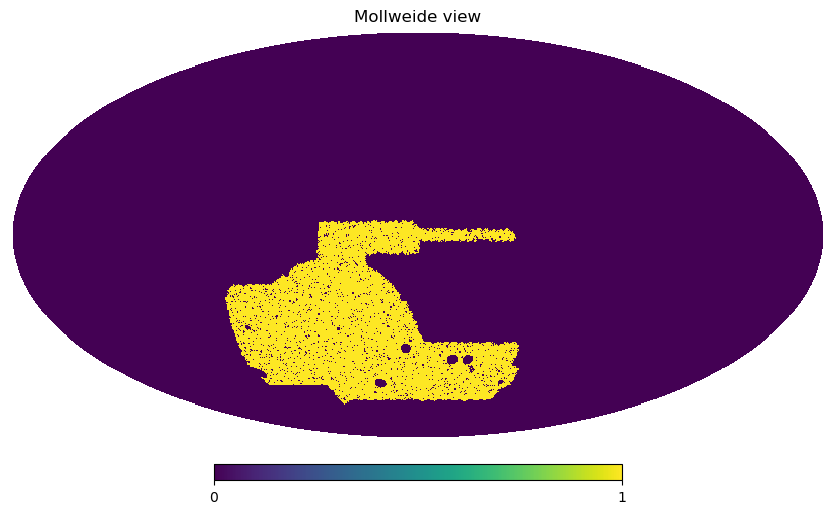

In [3]:
index_dir = "/Users/arne/data/DESY3/public/DESY3_indexcat.h5"
with h5py.File(index_dir, "r") as f:
    indices_maglim = f["index/maglim/select"][:]

maglim_dir = "/Users/arne/data/DESY3/public/DESY3_maglim_redmagic_v0.5.1.h5"
with h5py.File(maglim_dir, "r") as catalog_ml:
    dec_maglim_deg = catalog_ml['catalog/maglim/dec'][:]
    ra_maglim_deg = catalog_ml['catalog/maglim/ra'][:]
    w_maglim = catalog_ml['catalog/maglim/weight'][:]

dnf_dir = "/Users/arne/data/DESY3/public/DESY3_GOLD_2_2.1_DNF.h5"
with h5py.File(dnf_dir, "r") as f:
    z_mean = f["catalog/unsheared/zmean_sof"][:][indices_maglim]

# redshift bin definitions
z_mask_tot = (0.2 < z_mean) & (z_mean < 1.05)
z_masks = [
    (0.2 < z_mean) & (z_mean < 0.4),
    (0.4 < z_mean) & (z_mean < 0.55),
    (0.55 < z_mean) & (z_mean < 0.70),
    (0.70 < z_mean) & (z_mean < 0.85),
    (0.85 < z_mean) & (z_mean < 0.95),
    (0.95 < z_mean) & (z_mean < 1.05),
]

# reduce the gold catalog to the MagLim sample
dec_maglim_deg = dec_maglim_deg[indices_maglim]
ra_maglim_deg = ra_maglim_deg[indices_maglim]
w_maglim = w_maglim[indices_maglim]

# apply redshift cut to the maglim sample
redshift_mask = z_masks[maglim_tomo]
dec_maglim_deg = dec_maglim_deg[redshift_mask]
ra_maglim_deg = ra_maglim_deg[redshift_mask]
w_maglim = w_maglim[redshift_mask]

assert dec_maglim_deg.shape == ra_maglim_deg.shape == w_maglim.shape

# angles like in healpy in radian
theta_maglim = - dec_maglim_deg * np.pi/180 + np.pi/2
phi_maglim = ra_maglim_deg * np.pi/180

print(dec_maglim_deg.shape)

# galaxy level: derived pixel ids, shape (num_galaxies,)
maglim_inds = hp.ang2pix(nside=nside, theta=theta_maglim, phi=phi_maglim)

# pixel level: derived pixel ids and number of galaxies per pixel
maglim_patch_pix, maglim_n_gal = np.unique(maglim_inds, return_counts=True)
maglim_anti_patch_pix = np.setdiff1d(np.arange(npix), maglim_patch_pix)

# number of galaxies per pixel
maglim_counts = np.zeros(npix)
maglim_counts[maglim_patch_pix] = maglim_n_gal

maglim_mask = np.zeros(npix)
maglim_mask[maglim_patch_pix] = 1

hp.mollview(maglim_mask)

# Gold mask

In [4]:
gold_dir = "/Users/arne/data/DESY3/public/DESY3_GOLD_2_2.1.h5"

with h5py.File(gold_dir, "r") as f:
    gold_mask_indices = f["masks/gold/hpix"][:]
    print(f["masks"].keys())
    print(f["catalog/gold"].keys())


<KeysViewHDF5 ['gold']>
<KeysViewHDF5 ['coadd_object_id', 'dec', 'extended_class_mash_sof', 'extended_class_sof', 'flags', 'flags_badregions', 'flags_footprint', 'flags_foreground', 'flags_gold', 'flags_phot', 'hpix_16384', 'ra', 'sof_cm_fracdev', 'sof_cm_mag_corrected_g', 'sof_cm_mag_corrected_i', 'sof_cm_mag_corrected_r', 'sof_cm_mag_corrected_z', 'sof_cm_mag_err_g', 'sof_cm_mag_err_i', 'sof_cm_mag_err_r', 'sof_cm_mag_err_z', 'sof_cm_t', 'sof_flags', 'tilename']>


21687208


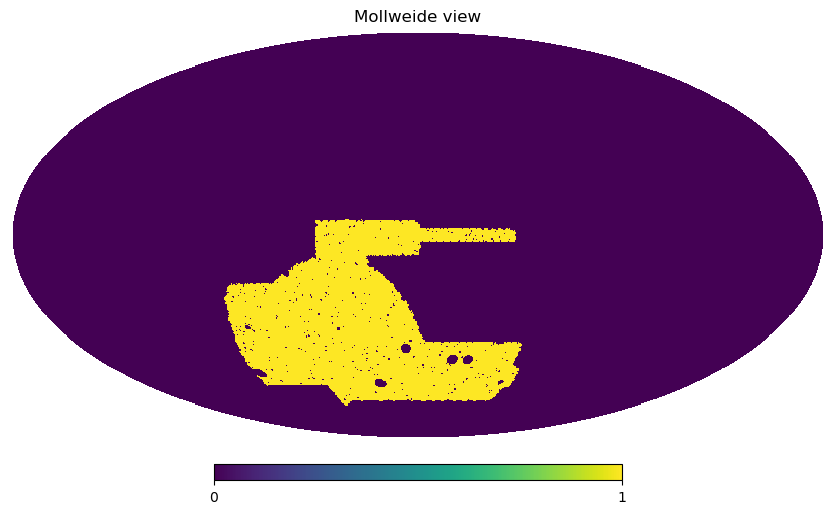

In [5]:
gold_mask = np.zeros(hp.nside2npix(4096))
gold_mask[gold_mask_indices] = 1

gold_mask = hp.ud_grade(gold_mask, nside_out=nside, order_in="NEST", order_out="RING")
gold_mask[gold_mask>0] = 1

hp.mollview(gold_mask)
print(len(gold_mask_indices))

# Martin's mask

In [6]:
martin_dir = "/Users/arne/data/DESY3/masks/maglim_mask_nside_512.fits.gz"

data, header = fits.getdata(martin_dir, header = True)

martin_inds = data["HPIX"]

array([1424391, 1424392, 1424393, ..., 3025349, 3025350, 3025351])

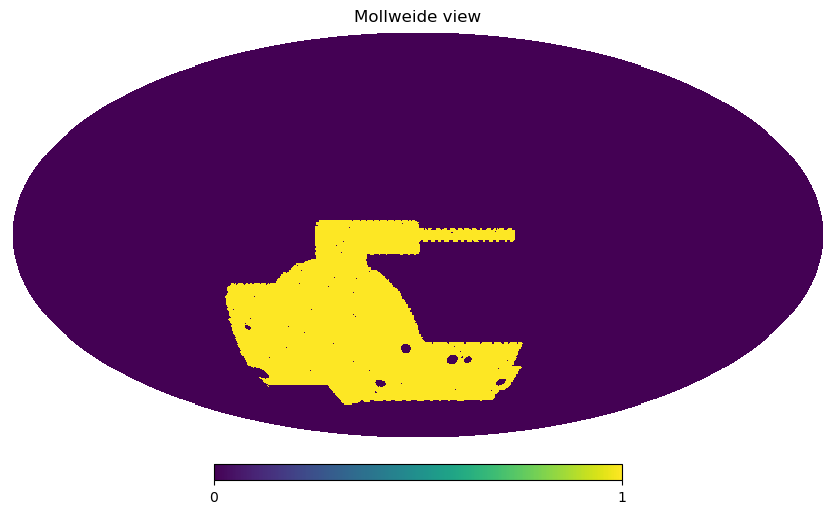

In [7]:
martin_mask = np.zeros(npix)
martin_mask[martin_inds] = 1

hp.mollview(martin_mask)

data["HPIX"]

# Martin's systematics mask

In [8]:
fits_dir = f"/Users/arne/data/DESY3/systematics_analysis/pca_tests/maglim_v2.2_new_zbinning_jointmask/pca_107_maps/jointmask_w_maps_nbins1d_10_2.0sig_pca_maps_107_50_cut/w_map_bin{maglim_tomo}_nside4096_nbins1d_10_2sig_v2.0.fits.gz"
w_map_first_bin, header_w_map_first_bin = fits.getdata(fits_dir, header = True)

systematics_patch_pix = w_map_first_bin["HPIX"]

systematics_mask = np.zeros(hp.nside2npix(4096))
systematics_mask[systematics_patch_pix] = 1
systematics_mask = hp.ud_grade(systematics_mask, nside_out=512)
systematics_mask[systematics_mask>0] = 1

# Comparisons

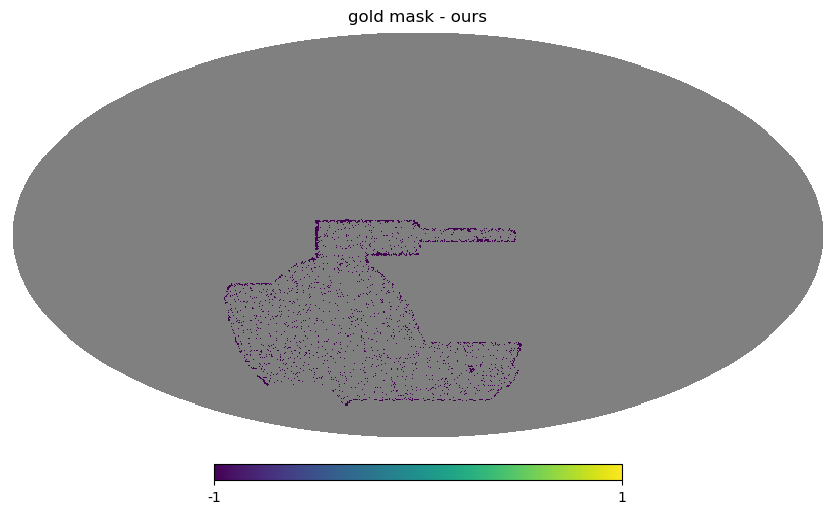

In [9]:
diff_map = maglim_mask - gold_mask
diff_map[diff_map==0] = hp.UNSEEN
hp.mollview(diff_map, title="gold mask - ours", min=-1, max=1)

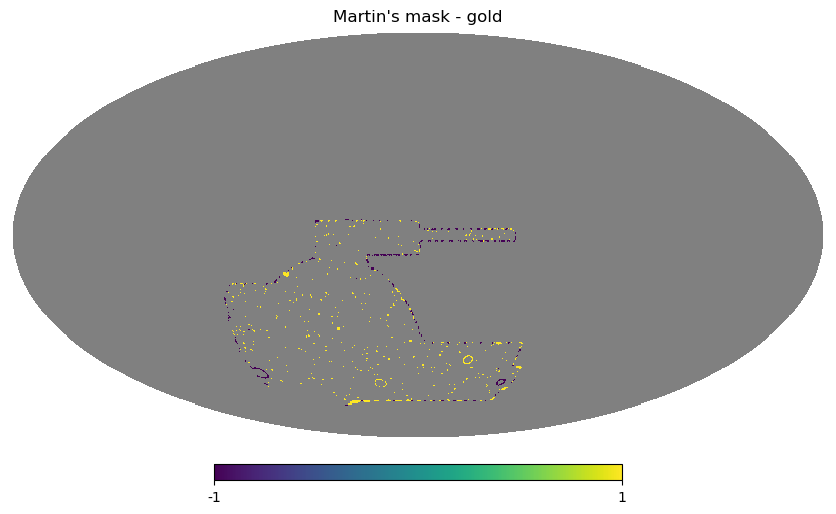

In [10]:
diff_map = martin_mask - gold_mask
diff_map[diff_map==0] = hp.UNSEEN
hp.mollview(diff_map, title="Martin's mask - gold", min=-1, max=1)

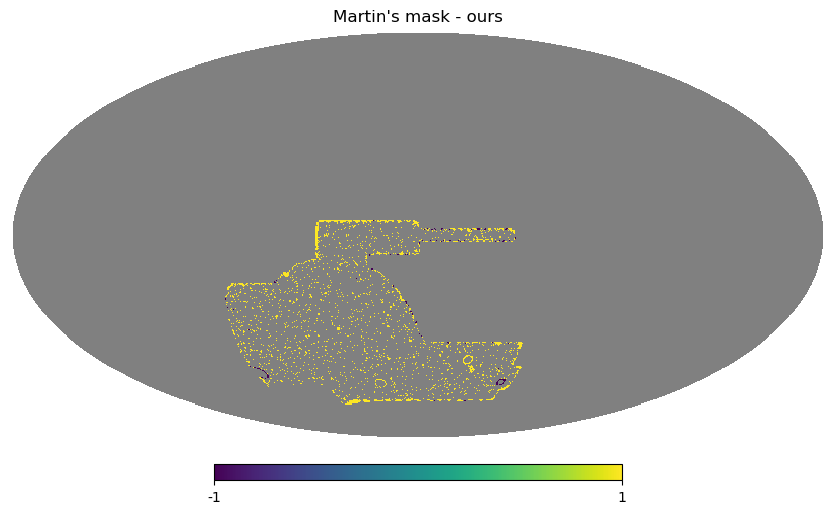

In [11]:
diff_map = martin_mask - maglim_mask
diff_map[diff_map==0] = hp.UNSEEN
hp.mollview(diff_map, title="Martin's mask - ours", min=-1, max=1)

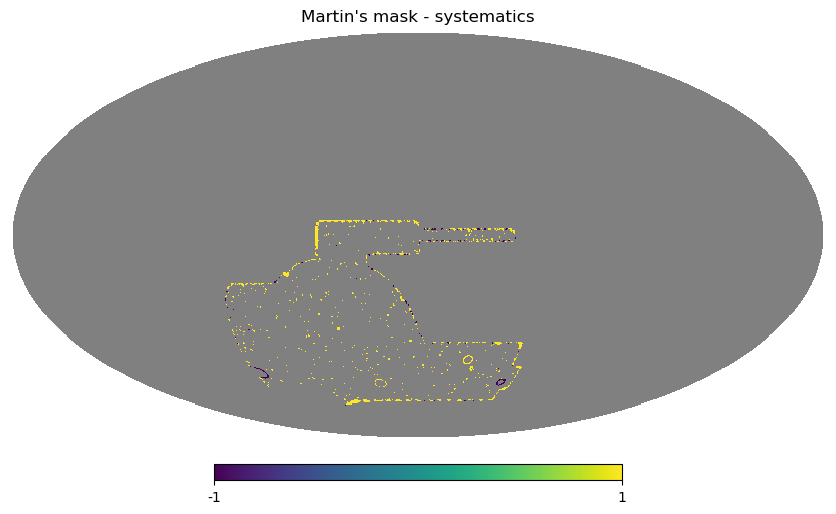

In [12]:
diff_map = martin_mask - systematics_mask
diff_map[diff_map==0] = hp.UNSEEN
hp.mollview(diff_map, title="Martin's mask - systematics", min=-1, max=1)